In [3]:
# 這行指令會強制把套件裝到當前的環境 (torch_env)
!C:\Users\Tawei\anaconda3\envs\torch_env\python.exe -m pip install timm

  Using cached timm-1.0.22-py3-none-any.whl.metadata (63 kB)
  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached typer_slim-0.20.0-py3-none-any.whl.metadata (16 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
Using cached timm-1.0.22-py3-none-any.whl (2.5 MB)
Using cached huggingface_hub-1.2.3-py3-none-any.whl (520 kB)
Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl (2.9 MB)
Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl (341 kB)
Using cached shellingham-1.5.4-py2.py3-none-any.whl (9.8 kB)
Using cached typer_slim-0.20.0-py3-none-any.whl (47 kB)
Using cached click-8.3.1-py3-none-any.whl (108 kB)

   ----------- ---------------------------- 2/7 [hf-xet]
   ----------------- ---------------------- 3/7 [click]
   --

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
!pip install timm

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm  # 必裝
import gc    # 記憶體清理用

# ==========================================
# 1. 全局設定 (請修改這裡的路徑)
# ==========================================
GLOBAL_SETTINGS = {
    # 建議設為 8 以避免顯存不足 (OOM)，如果您是用 RTX 3090/4090 可改 16
    "batch_size": 8,     
    "num_epochs": 4,     # 每個配置跑 4 Epochs (總共約需 5-8 小時)
    "img_size": 224,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    # --- 請修改您的 Windows 路徑 ---
    "train_dir": r"C:\Users\Tawei\Downloads\nycu2025dlfp\train", 
    "test_dir":  r"C:\Users\Tawei\Downloads\nycu2025dlfp\test",
}

# 8 種策略配置 (差異化集成)
CONFIGS = {
    1: {"name": "Anchor",       "model": "dino",     "unfreeze": 2, "aug": "std",  "seed": 42},  # 基準
    2: {"name": "DeepMiner",    "model": "dino",     "unfreeze": 5, "aug": "std",  "seed": 42},  # 深層挖掘
    3: {"name": "BlurExpert",   "model": "dino",     "unfreeze": 2, "aug": "hard", "seed": 42},  # 抗噪專家
    4: {"name": "CNN_Master",   "model": "convnext", "unfreeze": 0, "aug": "std",  "seed": 42},  # 紋理專家 (CNN)
    5: {"name": "Pooler",       "model": "dino_avg", "unfreeze": 2, "aug": "std",  "seed": 42},  # 全局視野
    6: {"name": "Twin_Anchor",  "model": "dino",     "unfreeze": 2, "aug": "std",  "seed": 100}, # 模型抖動 1
    7: {"name": "Twin_Deep",    "model": "dino",     "unfreeze": 5, "aug": "std",  "seed": 200}, # 模型抖動 2
    8: {"name": "Twin_Blur",    "model": "dino",     "unfreeze": 2, "aug": "hard", "seed": 300}, # 模型抖動 3
}

# ==========================================
# 2. 工具函式
# ==========================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def get_transforms(aug_level):
    if aug_level == "hard":
        # 強力模糊策略：強迫模型不看細節雜訊
        return transforms.Compose([
            transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.GaussianBlur(5, sigma=(0.1, 5.0))], p=0.5), # 50% 機率
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else: 
        # 標準策略
        return transforms.Compose([
            transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2), # 20% 機率
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==========================================
# 3. 資料集 Class
# ==========================================
class TrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = [] 
        
        real_path = os.path.join(root_dir, 'Real')
        if os.path.exists(real_path):
            imgs = glob.glob(os.path.join(real_path, '**', '*.*'), recursive=True)
            valid = [x for x in imgs if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.image_paths.extend(valid)
            self.labels.extend([0] * len(valid))
            
        fake_path = os.path.join(root_dir, 'Fake')
        if os.path.exists(fake_path):
            imgs = glob.glob(os.path.join(fake_path, '**', '*.*'), recursive=True)
            valid = [x for x in imgs if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.image_paths.extend(valid)
            self.labels.extend([1] * len(valid))

    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform: image = self.transform(image)
            return image, torch.tensor(self.labels[idx], dtype=torch.float32)
        except: return torch.zeros((3, 224, 224)), torch.tensor(0.0)

class SubmissionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root_dir, '**', '*.*'), recursive=True)
        self.image_paths = [x for x in self.image_paths if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        name = os.path.splitext(os.path.basename(path))[0]
        try:
            image = Image.open(path).convert('RGB')
            if self.transform: image = self.transform(image)
            return image, name
        except: return torch.zeros((3, 224, 224)), name

# ==========================================
# 4. 萬能模型架構 (Universal Model Factory)
# ==========================================
class UniversalModel(nn.Module):
    def __init__(self, cfg):
        super(UniversalModel, self).__init__()
        self.cfg = cfg
        
        if "dino" in cfg['model']:
            # DINOv2 Large
            self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
            self.embed_dim = 1024
            
            # 預設先全凍結
            for param in self.backbone.parameters(): param.requires_grad = False
            
            # 根據設定解凍層數
            if isinstance(cfg['unfreeze'], int):
                n_layers = cfg['unfreeze']
                # 解凍最後 n 層 Blocks
                for i in range(1, n_layers + 1):
                    for param in self.backbone.blocks[-i].parameters(): param.requires_grad = True
                # 解凍 Norm 層
                for param in self.backbone.norm.parameters(): param.requires_grad = True
            
            self.head = nn.Sequential(
                nn.Linear(self.embed_dim, 512),
                nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.4),
                nn.Linear(512, 1)
            )
            
        elif "convnext" in cfg['model']:
            # ConvNeXt V2 (CNN 架構)
            self.backbone = timm.create_model('convnextv2_base', pretrained=True, num_classes=0)
            self.embed_dim = 1024
            self.head = nn.Sequential(
                nn.Linear(self.embed_dim, 512),
                nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.4),
                nn.Linear(512, 1)
            )

    def forward(self, x):
        if "dino" in self.cfg['model']:
            if "avg" in self.cfg['model']: 
                # 策略 5: 使用 Patch Tokens 的平均值 (Pooler)
                features_dict = self.backbone.forward_features(x)
                features = features_dict['x_norm_patchtokens'].mean(dim=1)
            else:
                features = self.backbone(x)
        else:
            features = self.backbone(x)
        return self.head(features)

# ==========================================
# 5. 單一配置執行函式
# ==========================================
def run_one_config(config_id):
    cfg = CONFIGS[config_id]
    print(f"\n{'='*50}")
    print(f"🚀 [進度 {config_id}/8] 正在執行配置: {cfg['name']}")
    print(f"   參數: Model={cfg['model']}, Unfreeze={cfg['unfreeze']}, Aug={cfg['aug']}, Seed={cfg['seed']}")
    print(f"{'='*50}")
    
    # 1. 設定種子
    set_seed(cfg['seed'])
    
    # 2. 準備資料
    current_transform = get_transforms(cfg['aug'])
    train_ds = TrainDataset(GLOBAL_SETTINGS['train_dir'], transform=current_transform)
    # Windows 必須設 num_workers=0
    train_loader = DataLoader(train_ds, batch_size=GLOBAL_SETTINGS['batch_size'], shuffle=True, num_workers=0)
    
    # 3. 準備模型與優化器
    model = UniversalModel(cfg).to(GLOBAL_SETTINGS['device'])
    criterion = nn.BCEWithLogitsLoss()
    
    if "convnext" in cfg['model']:
        optimizer = optim.AdamW(model.parameters(), lr=5e-5) # CNN 統一 LR
    else:
        # DINO 差異化學習率
        lr_backbone = 1e-5
        if cfg['unfreeze'] == 5: lr_backbone = 5e-6 # 解凍越多，LR 越小
        optimizer = optim.AdamW([
            {'params': model.backbone.parameters(), 'lr': lr_backbone},
            {'params': model.head.parameters(), 'lr': 1e-4}
        ])

    # 4. 訓練迴圈
    for epoch in range(GLOBAL_SETTINGS['num_epochs']):
        model.train()
        run_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Config {config_id} | Epoch {epoch+1}")
        
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(GLOBAL_SETTINGS['device']), lbls.to(GLOBAL_SETTINGS['device']).unsqueeze(1)
            
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward()
            optimizer.step()
            
            run_loss += loss.item()
            pbar.set_postfix({'loss': run_loss/(pbar.n+1)})
            
    # 5. 存檔模型
    save_path = f"model_run_{config_id}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"✅ 模型 {config_id} 已儲存")
    
    # 6. 生成預測 (使用 TTA)
    print(f"   正在生成預測 (含 TTA 增強)...")
    sub_ds = SubmissionDataset(GLOBAL_SETTINGS['test_dir'], transform=test_transforms)
    sub_loader = DataLoader(sub_ds, batch_size=GLOBAL_SETTINGS['batch_size'], shuffle=False, num_workers=0)
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for imgs, names in tqdm(sub_loader):
            imgs = imgs.to(GLOBAL_SETTINGS['device'])
            
            # TTA: 預測原圖 + 水平翻轉圖，取平均
            out1 = torch.sigmoid(model(imgs))
            out2 = torch.sigmoid(model(torch.flip(imgs, [3])))
            prob = (out1 + out2) / 2.0
            
            for n, p in zip(names, prob.cpu().numpy().flatten()):
                results.append({'filename': n, 'prob': p})
    
    df = pd.DataFrame(results)
    csv_path = f"submission_run_{config_id}.csv"
    df.to_csv(csv_path, index=False)
    print(f"✅ 預測檔 submission_run_{config_id}.csv 已生成")
    
    # 7. 清理記憶體 (防止當機)
    del model, optimizer, train_loader, sub_loader
    torch.cuda.empty_cache()
    gc.collect()

# ==========================================
# 6. 主程式
# ==========================================
if __name__ == "__main__":
    print("🔥 全自動訓練腳本啟動 (1~8)...")
    
    for i in range(1, 9):
        try:
            run_one_config(i)
        except Exception as e:
            print(f"❌ Config {i} 發生錯誤: {e}")
            import traceback
            traceback.print_exc()
            
    print("\n🎉 全部訓練結束！請執行 ensemble_script.py 來合併結果。")

In [1]:
import sys
print("當前 Python 執行路徑:", sys.executable)

try:
    import timm
    print("timm 安裝路徑:", timm.__file__)
except ImportError:
    print("仍然抓不到 timm")

當前 Python 執行路徑: C:\Users\Tawei\anaconda3\envs\torch_env\python.exe
仍然抓不到 timm


In [1]:
import pandas as pd
import glob
import os

print("--- 開始集成 (Ensemble) ---")

# 1. 搜尋所有 submission_run_*.csv
csv_files = glob.glob("submission_run_*.csv")
print(f"找到 {len(csv_files)} 個預測檔: {csv_files}")

if len(csv_files) > 0:
    # 2. 讀取第一個檔案作為基底
    df_sum = pd.read_csv(csv_files[0])
    df_sum['filename'] = df_sum['filename'].astype(str)
    df_sum = df_sum.set_index('filename')
    
    df_sum['prob'] = df_sum['prob'].astype(float)
    
    # 3. 讀取剩下的檔案並加總機率
    for f in csv_files[1:]:
        df_new = pd.read_csv(f)
        df_new['filename'] = df_new['filename'].astype(str)
        df_new = df_new.set_index('filename')
        
        # 把機率加進去
        df_sum['prob'] += df_new['prob'].astype(float)
        
    # 4. 取平均
    df_sum['prob'] /= len(csv_files)
    
    # 5. 轉換成標籤 (0.5 為界線)
    df_sum['label'] = df_sum['prob'].apply(lambda x: 'fake' if x > 0.5 else 'real')
    
    # 6. 整理並輸出
    df_final = df_sum.reset_index()
    
    # 數字排序
    try:
        df_final['sort_key'] = pd.to_numeric(df_final['filename'])
        df_final = df_final.sort_values('sort_key').drop('sort_key', axis=1)
    except: pass
        
    output_filename = "final_ensemble_submission.csv"
    df_final[['filename', 'label']].to_csv(output_filename, index=False)
    
    print(f"🏆 最終集成檔案已生成: {os.path.abspath(output_filename)}")
    print(df_final.head())
else:
    print("❌ 沒找到任何 submission 檔案，請確認訓練是否完成。")

--- 開始集成 (Ensemble) ---
找到 6 個預測檔: ['submission_run_1.csv', 'submission_run_2.csv', 'submission_run_3.csv', 'submission_run_4.csv', 'submission_run_5.csv', 'submission_run_6.csv']
🏆 最終集成檔案已生成: C:\Users\Tawei\final_ensemble_submission.csv
     filename      prob label
0           1  0.838649  fake
5112        2  0.377789  real
6223        3  0.999713  fake
7334        4  0.987094  fake
8445        5  0.557330  fake


--- 模型相關性矩陣 ---
                  submission_run_1  submission_run_2  submission_run_3  \
submission_run_1          1.000000          0.905376          0.927049   
submission_run_2          0.905376          1.000000          0.886964   
submission_run_3          0.927049          0.886964          1.000000   
submission_run_4          0.706540          0.687259          0.718956   
submission_run_5          0.943518          0.912426          0.925524   
submission_run_6          0.916509          0.915505          0.919325   

                  submission_run_4  submission_run_5  submission_run_6  
submission_run_1          0.706540          0.943518          0.916509  
submission_run_2          0.687259          0.912426          0.915505  
submission_run_3          0.718956          0.925524          0.919325  
submission_run_4          1.000000          0.703636          0.702395  
submission_run_5          0.703636          1.000000          0.912753  
submission_run_6          0

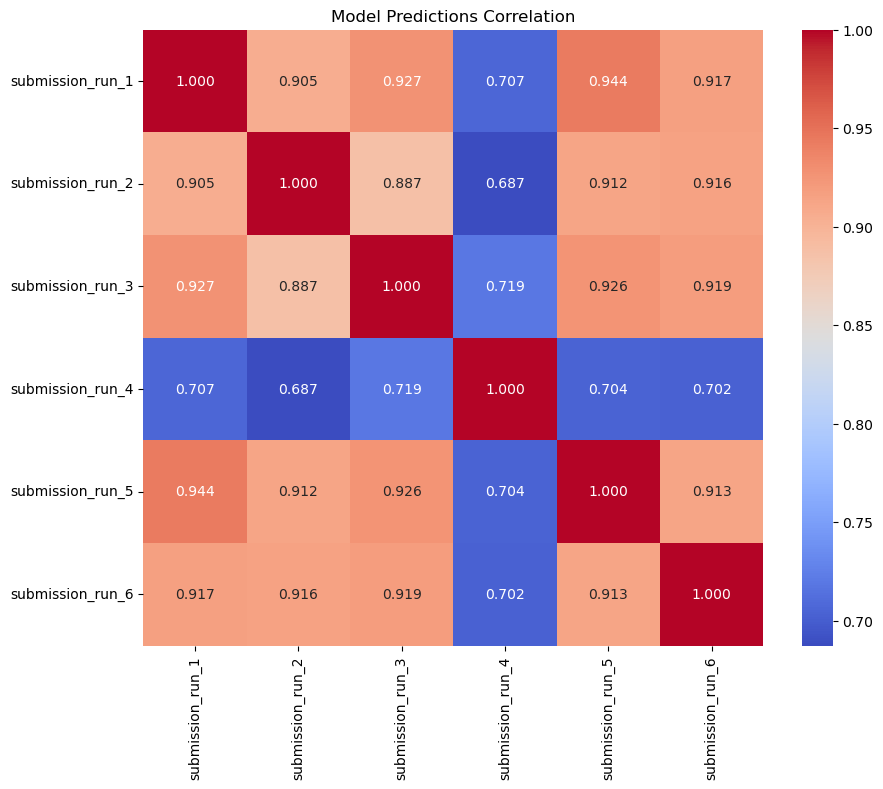

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# 讀取所有預測檔
files = sorted(glob.glob("submission_run_*.csv"))
data = {}

for f in files:
    name = f.split("\\")[-1].replace(".csv", "") # 抓檔名
    df = pd.read_csv(f)
    # 依檔名排序確保對齊
    try:
        df['sort'] = pd.to_numeric(df['filename'])
        df = df.sort_values('sort')
    except: pass
    data[name] = df['prob'].values

# 建立 DataFrame
df_corr = pd.DataFrame(data)

# 計算相關係數 (Pearson Correlation)
corr_matrix = df_corr.corr()

print("--- 模型相關性矩陣 ---")
print(corr_matrix)

# 畫圖 (如果是在 Jupyter)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Model Predictions Correlation")
plt.show()

In [11]:
import pandas as pd

print("--- 正在執行修正版階層式集成 ---")

# 1. 讀取 DINO 陣營 (Run 1, 2, 3, 5, 6)
# 請確認這幾個檔案都在資料夾內
dino_files = [
    "submission_run_1.csv", "submission_run_2.csv", "submission_run_3.csv",
    "submission_run_5.csv", "submission_run_6.csv"
]

# 讀取第一個當基底
df_dino = pd.read_csv(dino_files[0])
df_dino['filename'] = df_dino['filename'].astype(str) # 確保是字串
df_dino = df_dino.set_index('filename')

# 加總其他 DINO
for f in dino_files[1:]:
    df_temp = pd.read_csv(f)
    df_temp['filename'] = df_temp['filename'].astype(str)
    df_temp = df_temp.set_index('filename')
    df_dino['prob'] += df_temp['prob']

df_dino['prob'] /= len(dino_files) # 取平均

# 2. 讀取 CNN (Run 4)
df_cnn = pd.read_csv("submission_run_4.csv")
df_cnn['filename'] = df_cnn['filename'].astype(str)
df_cnn = df_cnn.set_index('filename')

# 3. 最終 PK (權重 0.6 : 0.4)
df_final = df_dino.copy()
df_final['prob'] = 0.7 * df_dino['prob'] + 0.3 * df_cnn['prob']

# 4. 轉 Label 並輸出
df_final['label'] = df_final['prob'].apply(lambda x: 'fake' if x > 0.5 else 'real')

# --- 🔥 修正點在這裡：強制只選取 filename 和 label 兩欄 ---
df_output = df_final.reset_index()[['filename', 'label']]

# 排序 (選用，為了美觀)
try:
    df_output['sort_key'] = pd.to_numeric(df_output['filename'])
    df_output = df_output.sort_values('sort_key').drop('sort_key', axis=1)
except: pass

output_name = "final_hierarchical_submission_fixed.csv"
df_output.to_csv(output_name, index=False)

print(f"✅ 格式修正完畢！已儲存為: {output_name}")
print("前 5 筆預覽 (請確認只有兩欄):")
print(df_output.head())

--- 正在執行修正版階層式集成 ---
✅ 格式修正完畢！已儲存為: final_hierarchical_submission_fixed.csv
前 5 筆預覽 (請確認只有兩欄):
     filename label
0           1  fake
5112        2  real
6223        3  fake
7334        4  fake
8445        5  fake
